In [65]:
from rasterio.plot import show
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df = pd.read_csv('/home/egodin/Documents/projects/mycoCarte/data/interim/model/testData.csv', index_col= 0)

# Remove bias features 
df = df.drop(['populationDensity',
                    'distanceToUrban',
                    'distanceRo',
                    'urbanArea',
                    'airesProtegees'
                    ], axis = 1)
print(df.head())

df = df.set_index('FID')

# Remove geo features,
df = df.drop(['block_id',
                    'regionCode'
                    ], axis = 1)
print(df.head())




     FID  block_id ty_couv_et  cl_dens  cl_haut  cl_age_et etagement  cl_pent  \
264  264         2          F      3.0      7.0  55.000000        MO      2.0   
265  265         2          R      4.0      7.0  82.857143        MO      1.0   
266  266         2          R      3.0      7.0  87.727273        MO      3.0   
267  267         2          R      3.0      7.0  95.000000        MO      3.0   
268  268         2         MF      3.0      6.0  99.000000        MO      4.0   

       hauteur                 dep_sur  ...   bioclim_04  bioclim_05  \
264  28.000000  Depot fluvio-glaciaire  ...  1150.548950   25.299999   
265  28.285714  Depot fluvio-glaciaire  ...  1150.548950   25.299999   
266  27.454545         Depot Glaciaire  ...  1154.230225   25.100000   
267  27.166667         Depot Glaciaire  ...  1154.230225   25.100000   
268  24.600000         Depot Glaciaire  ...  1156.614014   25.100000   

     bioclim_08  bioclim_09  bioclim_10  bioclim_12  bioclim_15  bioclim_16  \
2

                     cl_dens   cl_haut  cl_age_et   cl_pent   hauteur  \
cl_dens             1.000000  0.123685  -0.018578  0.111646  0.148789   
cl_haut             0.123685  1.000000   0.352823  0.054647  0.823446   
cl_age_et          -0.018578  0.352823   1.000000 -0.051877  0.408504   
cl_pent             0.111646  0.054647  -0.051877  1.000000  0.057394   
hauteur             0.148789  0.823446   0.408504  0.057394  1.000000   
cl_drai            -0.070013 -0.067914   0.002315 -0.518907 -0.082337   
tree_diver          0.092585  0.326368   0.081638 -0.055119  0.336268   
tree_shannon_index  0.101354  0.489526   0.329497  0.021369  0.576851   
bioclim_01          0.014104  0.435828   0.262348 -0.357202  0.556972   
bioclim_02          0.031857  0.343334   0.025381  0.049521  0.417654   
bioclim_03          0.057227  0.299177   0.033808  0.040599  0.356267   
bioclim_04         -0.022755  0.254510   0.021283 -0.005528  0.323998   
bioclim_05          0.006110  0.505514   0.234459 -

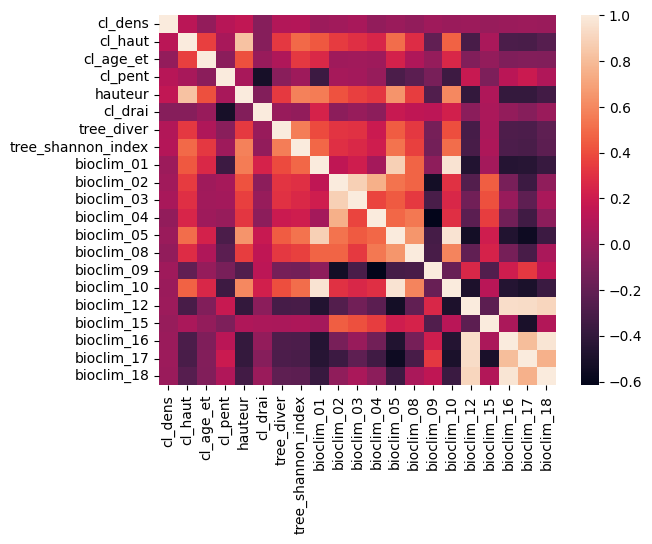

In [67]:
corr = df.corr(numeric_only= True)
sns.heatmap(corr)
print(corr)

In [68]:
# Remove colinear features 

df = df.drop(['hauteur',
              'bioclim_01',
              'bioclim_05'
              ], axis = 1)

In [69]:
#Removes Nans

print(df.shape)
df = df.dropna()
print(df.shape)

print(df.isna().sum())

(608492, 21)
(608492, 21)
ty_couv_et            0
cl_dens               0
cl_haut               0
cl_age_et             0
etagement             0
cl_pent               0
dep_sur               0
cl_drai               0
tree_diver            0
tree_shannon_index    0
bioclim_02            0
bioclim_03            0
bioclim_04            0
bioclim_08            0
bioclim_09            0
bioclim_10            0
bioclim_12            0
bioclim_15            0
bioclim_16            0
bioclim_17            0
bioclim_18            0
dtype: int64


In [70]:
# Split features
feature_names = []
nominal_feats = []
numeric_feats = []

for col in df.columns:
    feature_names.append(col)
    if col == 'FID':
        pass
    
    if df[col].dtype == 'object':
        nominal_feats.append(col) 
    else:
        numeric_feats.append(col)

print(feature_names)

index = df.index
print(index)

['ty_couv_et', 'cl_dens', 'cl_haut', 'cl_age_et', 'etagement', 'cl_pent', 'dep_sur', 'cl_drai', 'tree_diver', 'tree_shannon_index', 'bioclim_02', 'bioclim_03', 'bioclim_04', 'bioclim_08', 'bioclim_09', 'bioclim_10', 'bioclim_12', 'bioclim_15', 'bioclim_16', 'bioclim_17', 'bioclim_18']
Index([    264,     265,     266,     267,     268,     269,     270,     271,
           272,     273,
       ...
       1952286, 1953233, 1953234, 1953235, 1953236, 1954184, 1954185, 1954186,
       1955135, 1955136],
      dtype='int64', name='FID', length=608492)


In [71]:
# One Hot Encoding
categorical_features = nominal_feats

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_features])
df_nominal = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features), index= index)
print("After OneHotEncoding (if applied):")
print(df_nominal.head())

nominal_feats = encoder.get_feature_names_out(categorical_features)
nominal_feats = nominal_feats.tolist()
print(nominal_feats)
print(type(nominal_feats))

After OneHotEncoding (if applied):
     ty_couv_et_F  ty_couv_et_MF  ty_couv_et_MM  ty_couv_et_MR  ty_couv_et_R  \
FID                                                                            
264           1.0            0.0            0.0            0.0           0.0   
265           0.0            0.0            0.0            0.0           1.0   
266           0.0            0.0            0.0            0.0           1.0   
267           0.0            0.0            0.0            0.0           1.0   
268           0.0            1.0            0.0            0.0           0.0   

     etagement_BI  etagement_MO  etagement_MU  dep_sur_Autre depot  \
FID                                                                  
264           0.0           1.0           0.0                  0.0   
265           0.0           1.0           0.0                  0.0   
266           0.0           1.0           0.0                  0.0   
267           0.0           1.0           0.0         

In [72]:
#Feature Scaling
df_numerical = df[numeric_feats]
scaler = StandardScaler() # Or MinMaxScaler()
scaled_features = scaler.fit_transform(df_numerical)
print("\nScaled data (first 5 rows):")
df_scaled_numerical = pd.DataFrame(scaled_features, columns=numeric_feats, index= index)
print(df_scaled_numerical.head())


Scaled data (first 5 rows):
      cl_dens   cl_haut  cl_age_et   cl_pent   cl_drai  tree_diver  \
FID                                                                  
264 -0.382465  1.636363  -0.078661 -0.507587 -1.317848   -1.710175   
265  1.102218  1.636363   1.589858 -1.243776 -1.317848   -1.431556   
266 -0.382465  1.636363   1.881558  0.228601 -1.317848    0.797393   
267 -0.382465  1.636363   2.317162  0.228601 -1.317848    1.354630   
268 -0.382465  0.677964   2.556744  0.964790  0.117081    1.076011   

     tree_shannon_index  bioclim_02  bioclim_03  bioclim_04  bioclim_08  \
FID                                                                       
264           -1.343686    0.853705    0.873846    0.337683    0.468627   
265           -1.083103    0.853705    0.873846    0.337683    0.468627   
266           -0.128064    0.939366    0.973609    0.422878    0.435637   
267            0.208568    0.939366    0.973609    0.422878    0.435637   
268            0.398813    1.0

In [73]:
# Merge transformed features
df = pd.concat([df_scaled_numerical, df_nominal], axis=1)
print(df.head())


      cl_dens   cl_haut  cl_age_et   cl_pent   cl_drai  tree_diver  \
FID                                                                  
264 -0.382465  1.636363  -0.078661 -0.507587 -1.317848   -1.710175   
265  1.102218  1.636363   1.589858 -1.243776 -1.317848   -1.431556   
266 -0.382465  1.636363   1.881558  0.228601 -1.317848    0.797393   
267 -0.382465  1.636363   2.317162  0.228601 -1.317848    1.354630   
268 -0.382465  0.677964   2.556744  0.964790  0.117081    1.076011   

     tree_shannon_index  bioclim_02  bioclim_03  bioclim_04  ...  \
FID                                                          ...   
264           -1.343686    0.853705    0.873846    0.337683  ...   
265           -1.083103    0.853705    0.873846    0.337683  ...   
266           -0.128064    0.939366    0.973609    0.422878  ...   
267            0.208568    0.939366    0.973609    0.422878  ...   
268            0.398813    1.005990    1.039254    0.478045  ...   

     dep_sur_Depot Glaciaire  de

In [74]:
print(df.shape)
print(df.isna().sum())

(608492, 37)
cl_dens                           0
cl_haut                           0
cl_age_et                         0
cl_pent                           0
cl_drai                           0
tree_diver                        0
tree_shannon_index                0
bioclim_02                        0
bioclim_03                        0
bioclim_04                        0
bioclim_08                        0
bioclim_09                        0
bioclim_10                        0
bioclim_12                        0
bioclim_15                        0
bioclim_16                        0
bioclim_17                        0
bioclim_18                        0
ty_couv_et_F                      0
ty_couv_et_MF                     0
ty_couv_et_MM                     0
ty_couv_et_MR                     0
ty_couv_et_R                      0
etagement_BI                      0
etagement_MO                      0
etagement_MU                      0
dep_sur_Autre depot               0
dep_sur_Depot G

In [ ]:
#PCA (Principal Component Analysis):

# Decide on the number of components (e.g., to explain 95% of variance)
pca = PCA(n_components=0.95) 

# Or specify a fixed number: pca = PCA(n_components=3)
features_pca = pca.fit_transform(df[numeric_feats])

print(f"\nShape after PCA: {features_pca.shape}")
print(f"Explained variance ratio by chosen components: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_)}")

# For subsequent steps, decide whether to use 'scaled_features' or 'features_pca'
data_for_clustering = features_pca # or 
data_for_clustering = scaled_features


Shape after PCA: (608492, 10)
Explained variance ratio by chosen components: [0.30581942 0.15763404 0.1001365  0.09643868 0.05913728 0.05311728
 0.04805084 0.03950731 0.03165442 0.02814925]
Total explained variance: 0.9196450114229583


In [76]:
# The components are stored in the pca.components_ attribute
# It's best to view them in a DataFrame for clarity
components_df = pd.DataFrame(
    pca.components_,
    columns=numeric_feats,
    index=[f'PC-{i+1}' for i in range(pca.n_components_)]
)

print("--- PCA Component Loadings ---")
#print(components_df)

--- PCA Component Loadings ---


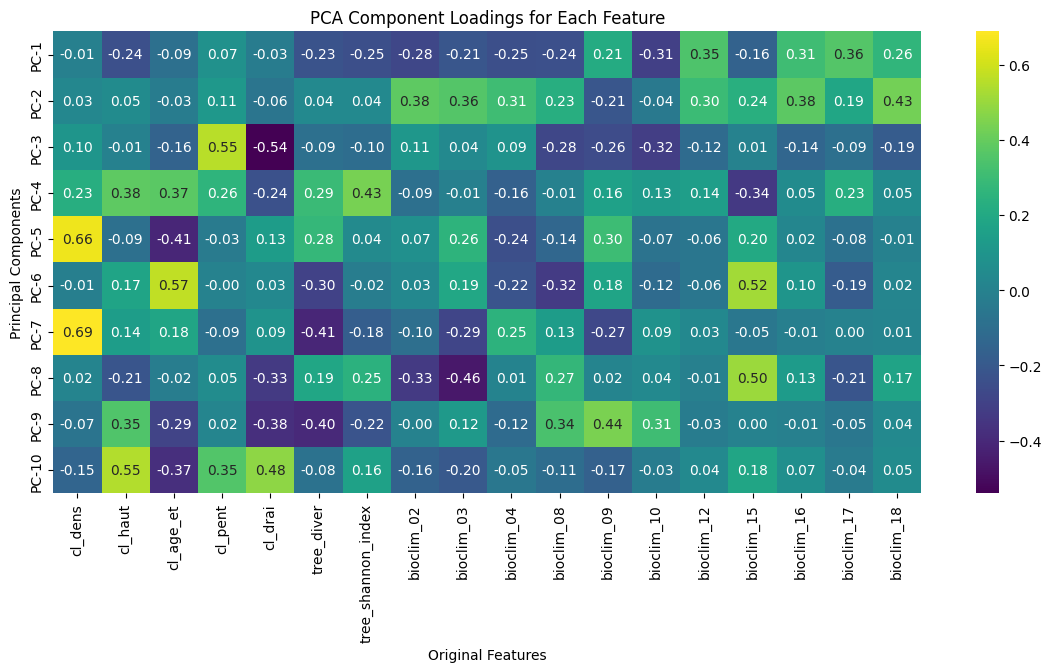

In [77]:
# 4. Visualize the Components for easier interpretation
plt.figure(figsize=(14, 6))
sns.heatmap(components_df, cmap="viridis", annot=True, fmt='.2f')
plt.title('PCA Component Loadings for Each Feature')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

In [78]:
# 5. Get the explained variance
explained_variance = pca.explained_variance_ratio_
print("\n--- Explained Variance by Each Component ---")
for i, variance in enumerate(explained_variance):
    print(f"PC-{i+1}: {variance:.3f} ({variance*100:.1f}%)")
print(f"Total Explained Variance: {np.sum(explained_variance):.3f} ({np.sum(explained_variance)*100:.1f}%)")


--- Explained Variance by Each Component ---
PC-1: 0.306 (30.6%)
PC-2: 0.158 (15.8%)
PC-3: 0.100 (10.0%)
PC-4: 0.096 (9.6%)
PC-5: 0.059 (5.9%)
PC-6: 0.053 (5.3%)
PC-7: 0.048 (4.8%)
PC-8: 0.040 (4.0%)
PC-9: 0.032 (3.2%)
PC-10: 0.028 (2.8%)
Total Explained Variance: 0.920 (92.0%)


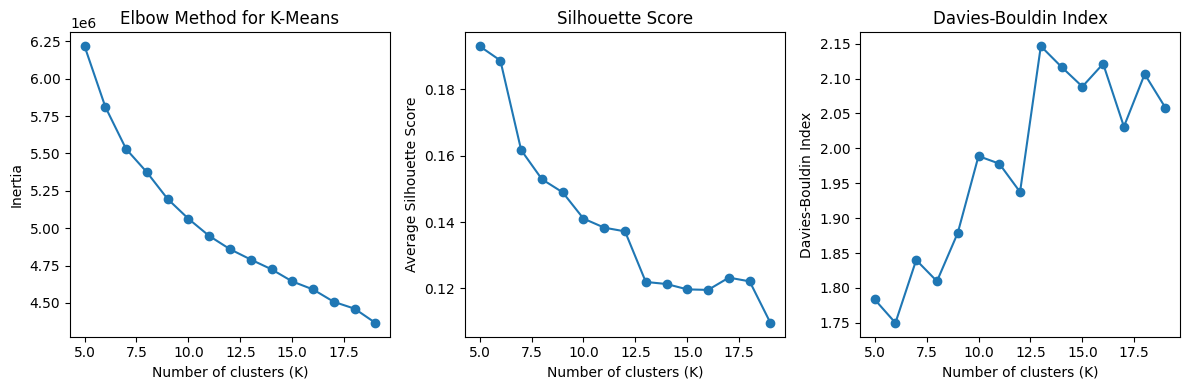

In [79]:
def kTests():
    k_range = range(5, 20) # Example range for K
    inertia_values = []
    silhouette_scores = []
    davies_bouldin_scores = []

    for k_test in k_range:
        # K-Means
        kmeans_test = KMeans(n_clusters=k_test, random_state=42, n_init='auto')
        kmeans_test.fit(data_for_clustering)
        inertia_values.append(kmeans_test.inertia_)
        
        # Silhouette Score (can be computationally expensive for large datasets)
        # For large datasets, you might use a sample:
        from sklearn.utils import resample
        sample_indices = resample(np.arange(data_for_clustering.shape[0]), n_samples=min(10000, data_for_clustering.shape[0]), random_state=42)
        sample_data = data_for_clustering[sample_indices]
        sample_labels = kmeans_test.predict(sample_data) # or predict on full and subset labels
        if len(np.unique(sample_labels)) > 1: # Silhouette needs at least 2 labels
            silhouette_scores.append(silhouette_score(sample_data, sample_labels))
            davies_bouldin_scores.append(davies_bouldin_score(sample_data, sample_labels))

        else:
            silhouette_scores.append(-1) # Invalid
            davies_bouldin_scores.append(float('inf'))
        labels_test = kmeans_test.labels_

        """
        if len(np.unique(labels_test)) > 1:
            silhouette_scores.append(silhouette_score(data_for_clustering, labels_test))
            davies_bouldin_scores.append(davies_bouldin_score(data_for_clustering, labels_test))
        else: # handles cases where K-Means might produce a single cluster (rare with n_init='auto')
            silhouette_scores.append(-1) 
            davies_bouldin_scores.append(float('inf'))
        """

    # Plotting the Elbow Method
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(k_range, inertia_values, marker='o')
    plt.title('Elbow Method for K-Means')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')

    # Plotting Silhouette Scores
    plt.subplot(1, 3, 2)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Average Silhouette Score')

    # Plotting Davies-Bouldin Index
    plt.subplot(1, 3, 3)
    plt.plot(k_range, davies_bouldin_scores, marker='o')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Davies-Bouldin Index')

    plt.tight_layout()
    plt.show()

kTests()

In [87]:
# --- Choose your K based on these plots and domain knowledge ---
# Example: Let's say K=4 seems optimal from the plots
optimal_k = 12
print(f"\nSelected optimal K: {optimal_k}")


Selected optimal K: 12


In [88]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(data_for_clustering)
algorithm_name = "KMeans"

In [89]:
df_with_clusters = df.copy() # Use the version before scaling for interpretability
df_with_clusters['cluster'] = cluster_labels
print(df_with_clusters.head())



      cl_dens   cl_haut  cl_age_et   cl_pent   cl_drai  tree_diver  \
FID                                                                  
264 -0.382465  1.636363  -0.078661 -0.507587 -1.317848   -1.710175   
265  1.102218  1.636363   1.589858 -1.243776 -1.317848   -1.431556   
266 -0.382465  1.636363   1.881558  0.228601 -1.317848    0.797393   
267 -0.382465  1.636363   2.317162  0.228601 -1.317848    1.354630   
268 -0.382465  0.677964   2.556744  0.964790  0.117081    1.076011   

     tree_shannon_index  bioclim_02  bioclim_03  bioclim_04  ...  \
FID                                                          ...   
264           -1.343686    0.853705    0.873846    0.337683  ...   
265           -1.083103    0.853705    0.873846    0.337683  ...   
266           -0.128064    0.939366    0.973609    0.422878  ...   
267            0.208568    0.939366    0.973609    0.422878  ...   
268            0.398813    1.005990    1.039254    0.478045  ...   

     dep_sur_Depot de pente  dep

In [90]:
df_out = df_with_clusters['cluster']
df_out.to_csv('/home/egodin/Documents/projects/mycoCarte/data/output/envClustering.csv')

In [91]:


numerical_cluster_profiles = df_with_clusters.groupby('cluster')[numeric_feats].agg(['mean', 'median'])

"""
nominal_cluster_profiles = pd.DataFrame()
for feat in nominal_feats:
    nominal_cluster_profile = df_with_clusters.groupby('cluster')[feat].agg(lambda x: x.mode()[0])
    nominal_cluster_profiles = nominal_cluster_profiles.merge(nominal_cluster_profile, left_index= True, right_on= 0)

cluster_profiles = pd.concat([numerical_cluster_profiles, nominal_cluster_profiles], axis=1)

"""

cluster_profiles = numerical_cluster_profiles
print(f"\n--- Cluster Profiles ({algorithm_name}) ---")
print(cluster_profiles)



--- Cluster Profiles (KMeans) ---
          cl_dens             cl_haut           cl_age_et             cl_pent  \
             mean    median      mean    median      mean    median      mean   
cluster                                                                         
0        0.172422 -0.382465  0.313759  0.677964 -0.339964 -0.453009  0.093300   
1        0.055689 -0.382465 -1.183701 -1.238832 -1.030241 -1.089399 -0.279950   
2       -0.211945 -0.382465 -0.203356 -0.280434  0.052222 -0.003792 -0.774811   
3       -0.204613 -0.382465  0.806477  0.677964  0.594235  0.605860  0.192434   
4        0.270773  1.102218  0.710060  0.677964  0.791721  0.744903 -1.046694   
5       -0.119922 -0.382465 -0.806911 -0.280434 -0.175426 -0.203444  0.689424   
6        0.385051  1.102218  0.737810  0.677964 -0.053357 -0.164226  0.777246   
7       -0.196175 -0.382465 -0.034131 -0.280434  0.214913  0.140956 -0.928876   
8       -1.364819 -1.867149 -1.240348 -1.238832 -0.897851 -0.977095 -0.789

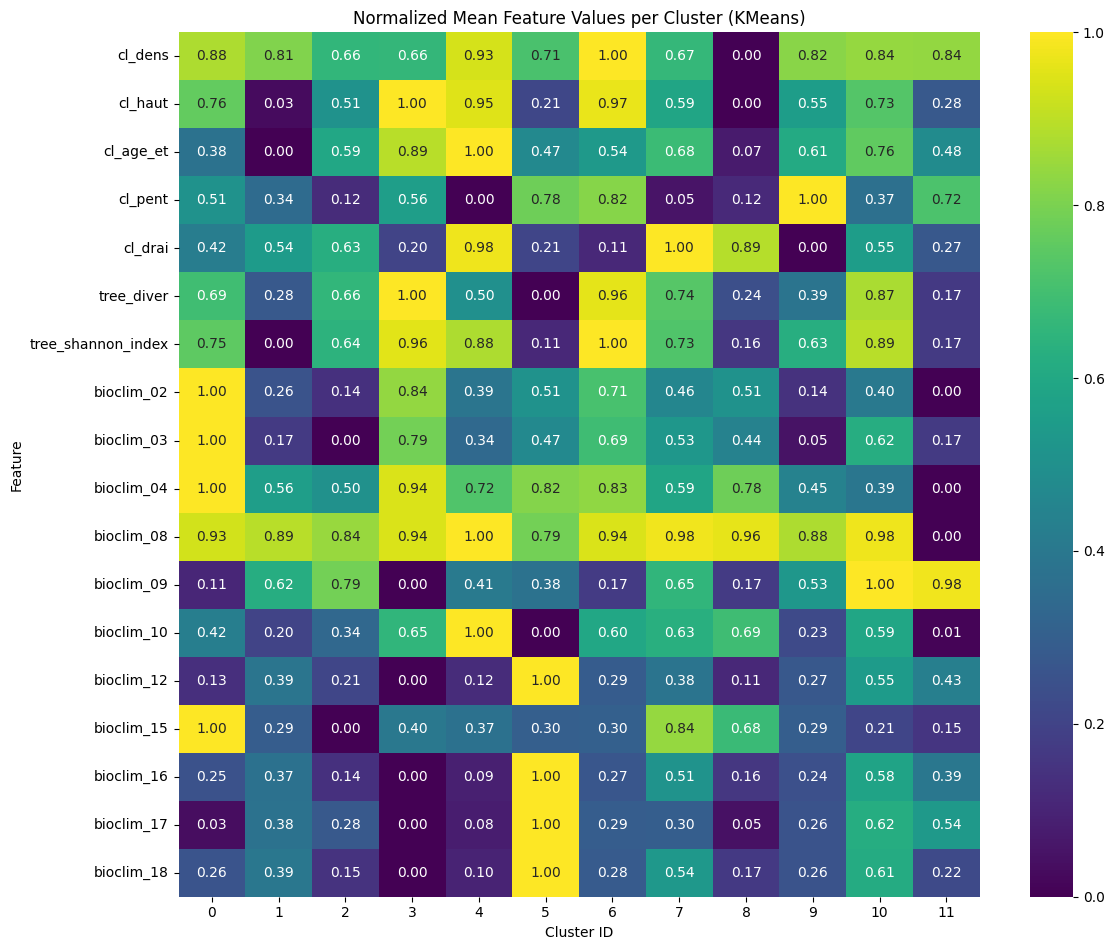

In [92]:
# Visualization of profiles
# Using mean values for demonstration
profile_plot_data = cluster_profiles.xs('mean', axis=1, level=1) # Get mean values

# It's often better to plot the scaled values if ranges are very different,
# or normalize the means for plotting on the same scale
profile_plot_data_normalized = (profile_plot_data - profile_plot_data.min()) / \
                               (profile_plot_data.max() - profile_plot_data.min())


plt.figure(figsize=(12, max(6, optimal_k * 0.8) )) # Adjust size based on K
sns.heatmap(profile_plot_data_normalized.T, annot=True, cmap="viridis", fmt=".2f")
plt.title(f'Normalized Mean Feature Values per Cluster ({algorithm_name})')
plt.xlabel('Cluster ID')
plt.ylabel('Feature')
plt.xticks(ticks=np.arange(optimal_k) + 0.5, labels=np.arange(optimal_k))
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


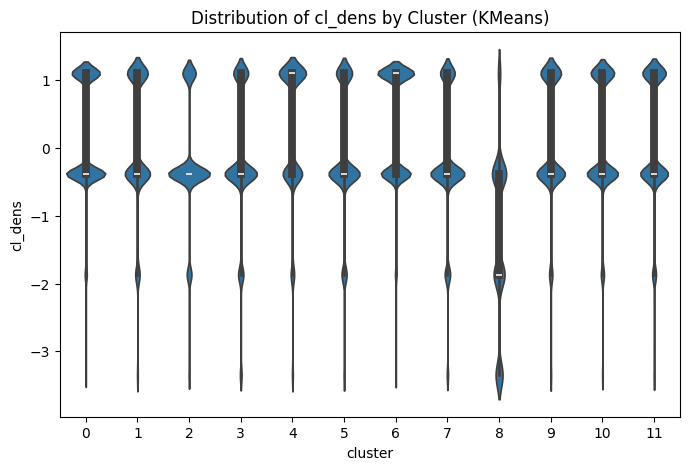

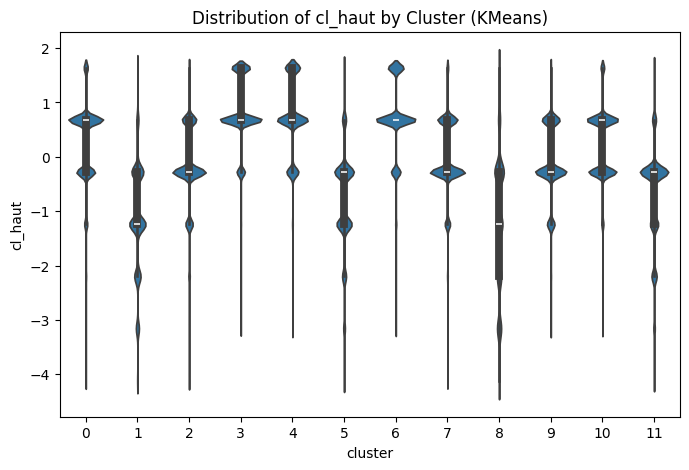

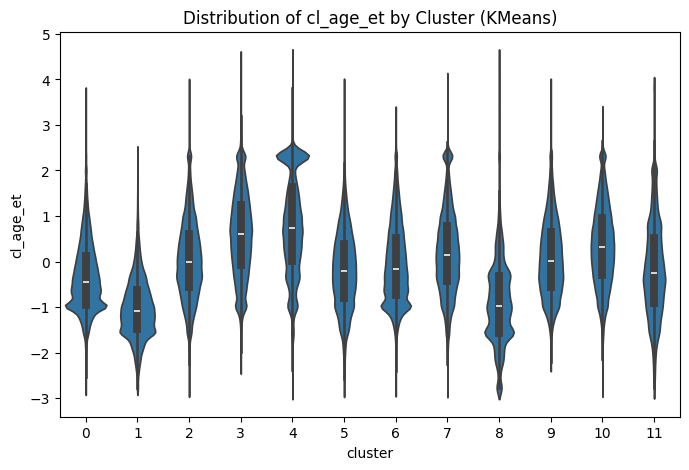

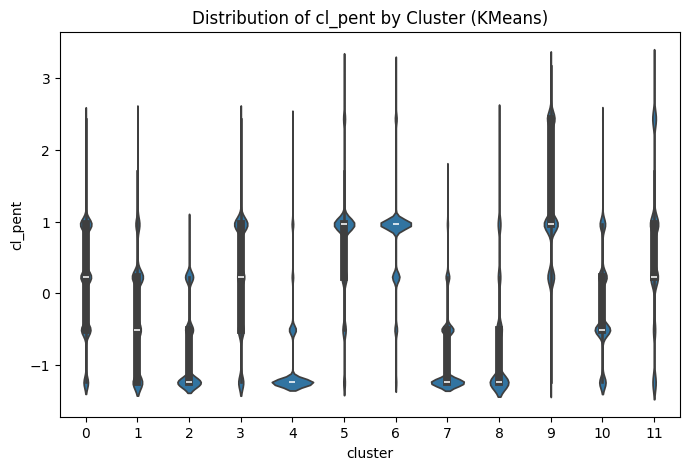

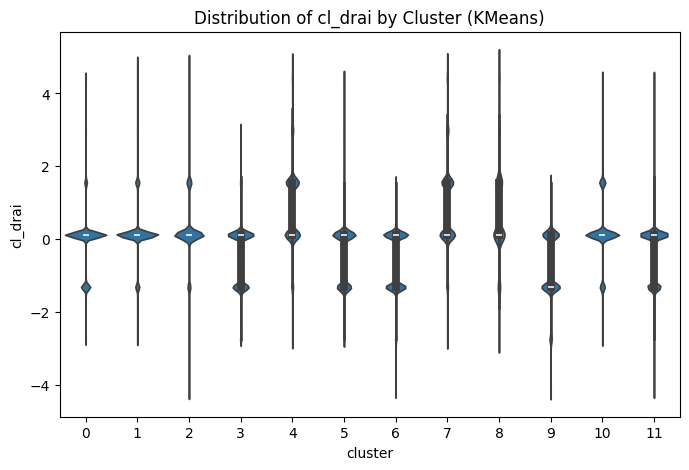

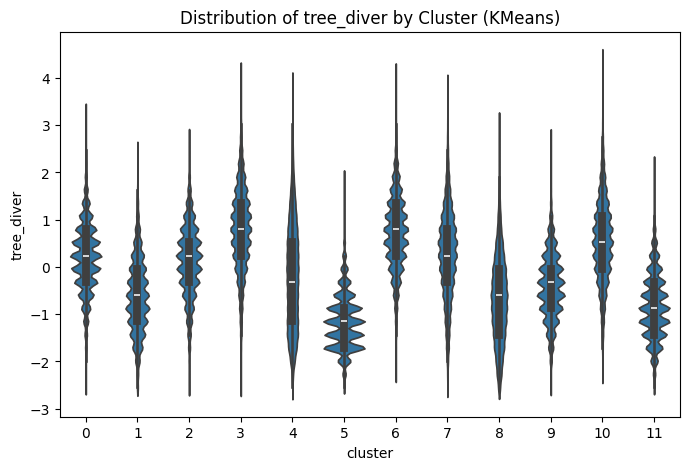

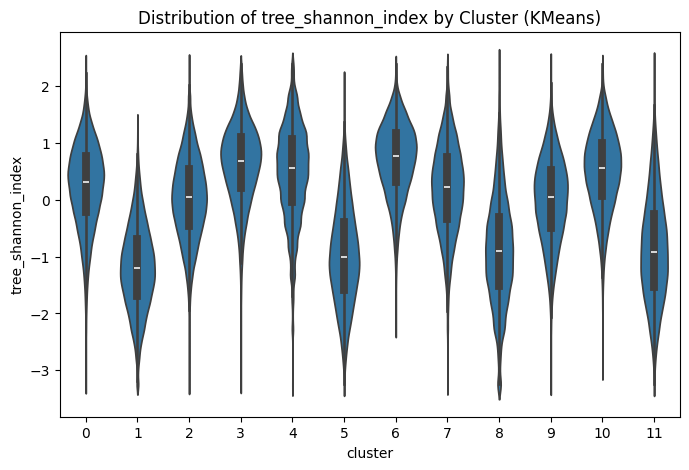

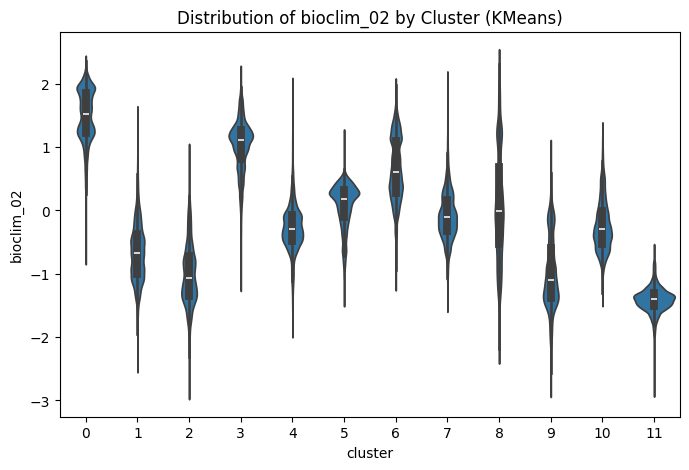

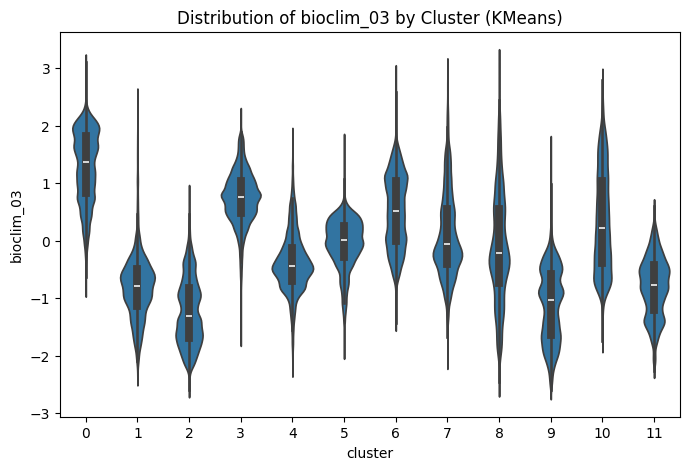

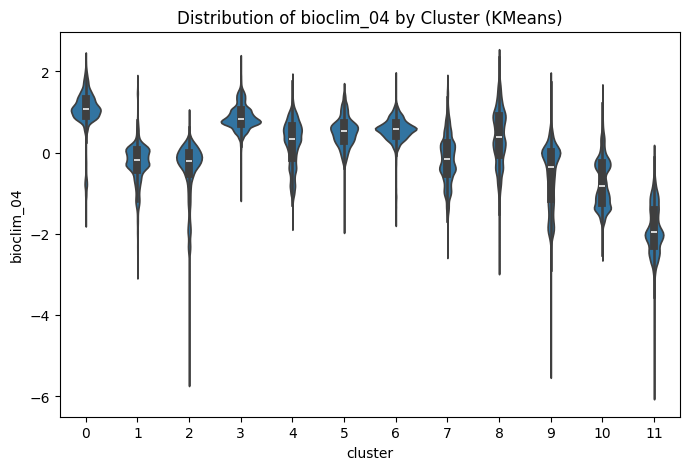

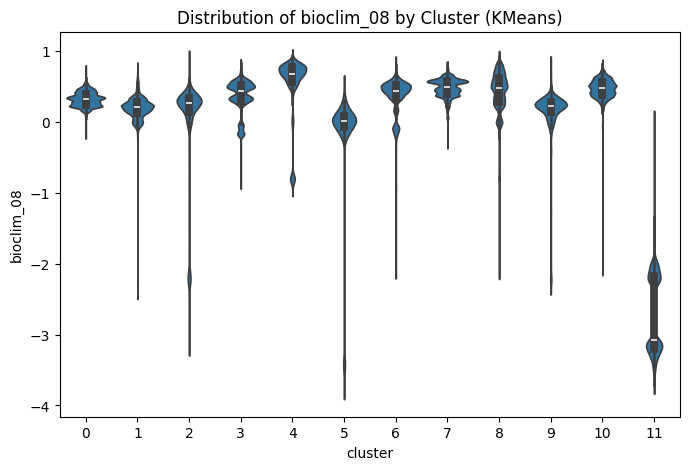

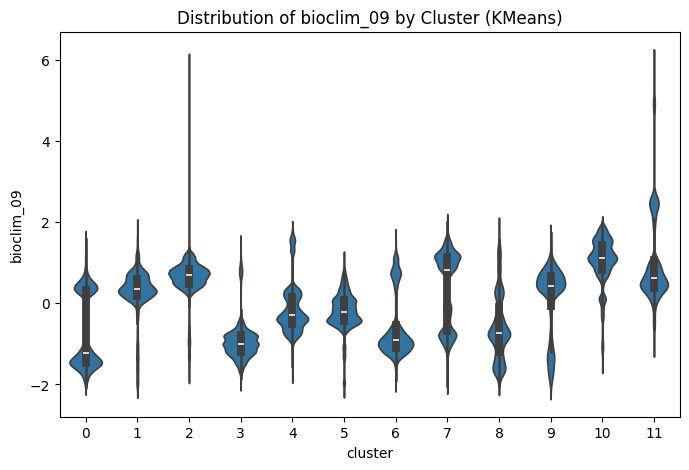

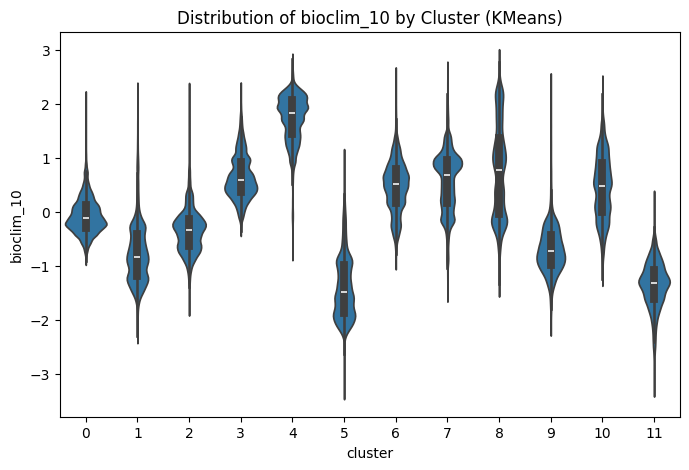

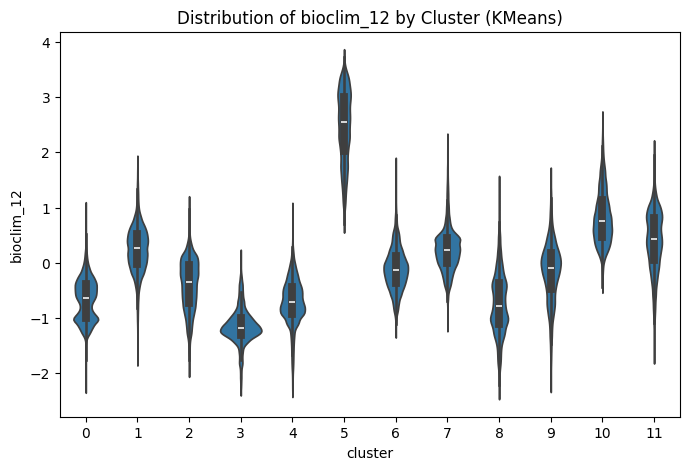

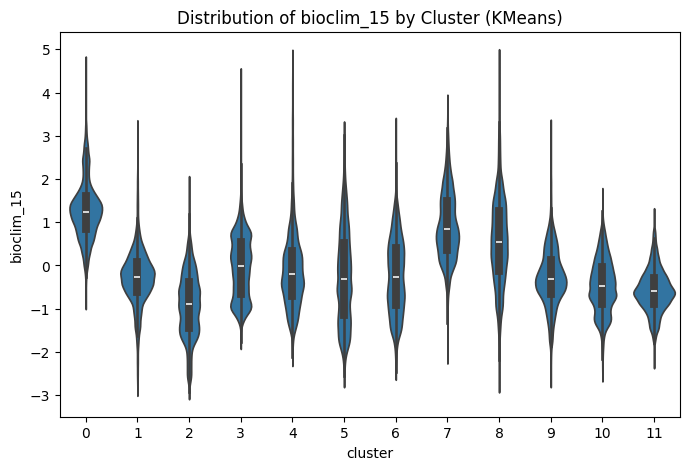

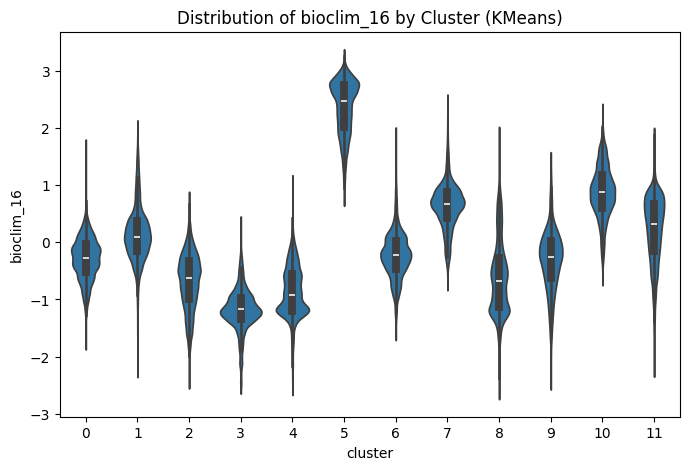

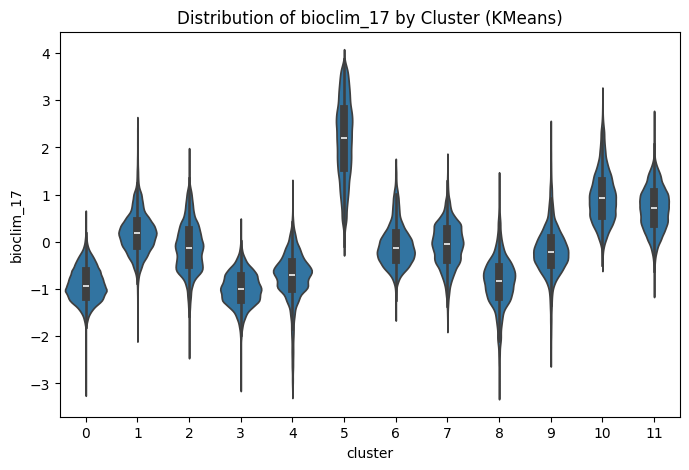

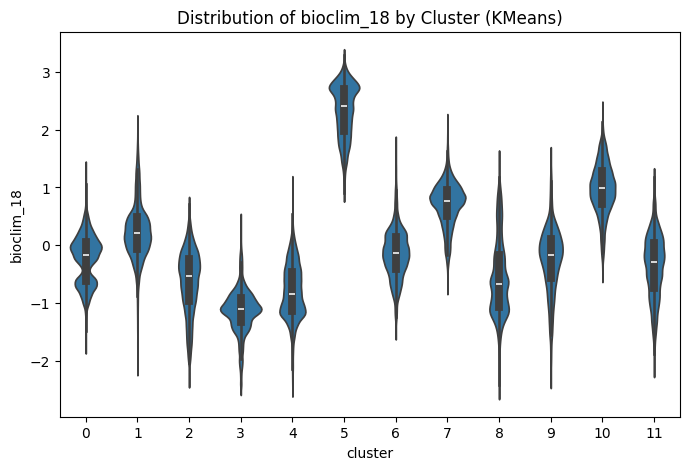

In [93]:

# Box plots for each feature by cluster
for feature in numeric_feats:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='cluster', y=feature, data=df_with_clusters)
    plt.title(f'Distribution of {feature} by Cluster ({algorithm_name})')
    plt.show()